### Read the LLM-classified data and present them
This is quite task-specific and may or may not be a helpful resource for other projects

In [1]:
import json, tqdm
import os
from pathlib import Path
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
with open("analyzed_papers.jsonl", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]
print(list(data[0]))
content_columns = ['fulltext', 'cleantext', 'pages_md']
metadata = [{k:v for k,v in e.items() if not k in content_columns} for e in data]
data = None
print("Metadata before error msg", len(metadata))
metadata = [e for e in metadata if not "error_msg" in e["analysis"]]
print("Metadata after error msg", len(metadata))

['semeval', 'id', 'bibkey', 'year', 'url', 'fulltext', 'cleantext', 'pages_md', 'status', 'analysis']
Metadata before error msg 1130
Metadata after error msg 1119


In [2]:
# Flatten the analysis
# print(metadata[0]["analysis"])
modelling_categories = []
records = []
for m in metadata:
    a = m["analysis"]
    record = {k:v for k,v in m.items() if not k == "analysis"}
    for key in [e for e in a if "categories" in e]:
        for item in a[key]:
            record[item] = 1
            modelling_categories.append(item)
    records.append(record)

# INspect keys in the returned analysis dict
Counter(modelling_categories).most_common(30)

[('FinetuningEncoder', 604),
 ('NonTransformerNN', 466),
 ('ClassicalML', 276),
 ('EmbeddingOnly', 206),
 ('LexiconBased', 200),
 ('Other', 116),
 ('PromptingDecoder', 103),
 ('FinetuningDecoder', 37)]

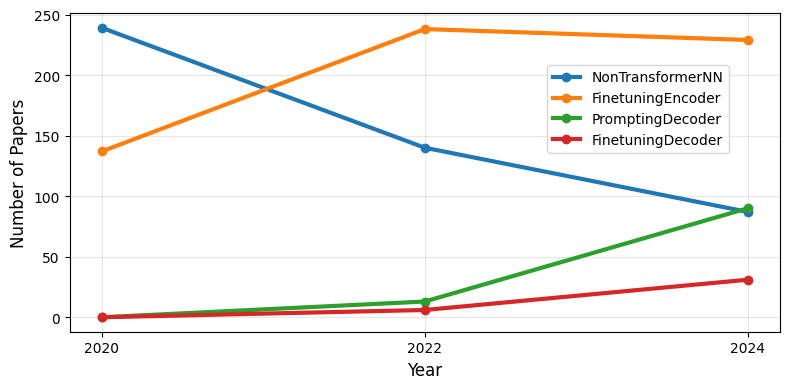

,year,FinetuningDecoder,Other,ClassicalML,LexiconBased,EmbeddingOnly,NonTransformerNN,FinetuningEncoder,PromptingDecoder,count
0,2020,0.0,18.0,125.0,73.0,102.0,239.0,137.0,0.0,373
1,2022,6.0,46.0,82.0,69.0,58.0,140.0,238.0,13.0,372
2,2024,31.0,52.0,69.0,58.0,46.0,87.0,229.0,90.0,374


In [10]:
# Look at per-year
df = pd.DataFrame.from_records(records)
modelling_cats = list(set(modelling_categories))
df_byyear = df[['year'] + modelling_cats].fillna(0).groupby(['year']).sum()

# Add row count per year
df_byyear['count'] = df.groupby('year').size()

# Make 'year' a regular column instead of index
df_byyear = df_byyear.reset_index()
df_byyear
keepers = [#'ClassicalML',
           'NonTransformerNN', 
           'FinetuningEncoder',  'PromptingDecoder','FinetuningDecoder']
 
plt.figure(figsize=(8, 4))

for category in keepers:
    plt.plot(df_byyear['year'], df_byyear[category], marker='o', label=category, linewidth=3)

# Customize the plot
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Papers', fontsize=12)
# plt.title('Evolution of Sentiment Analysis Modeling Methods', fontsize=12)
plt.legend(loc='center', bbox_to_anchor=(0.8, 0.7), fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Display
plt.savefig('modeling_trends.pdf', dpi=300, bbox_inches='tight')
plt.show()
df_byyear


In [4]:
# df[df["FinetuningDecoder"] == 1][["bibkey", "url"]]

[('has_sentiment_modelling', 1130),
 ('modelling_categories', 1119),
 ('other_method_categories', 1119),
 ('notes', 1119),
 ('error_msg', 11)]

In [5]:
# The papers above are interesting. We take a closer look.
import json, tqdm
import os
from pathlib import Path
from openai import OpenAI

# 1. Setup OpenRouter Client
# Assumes you have your key in ~/.keys/openrouter
key_path = Path.home() / ".keys" / "openrouter"
api_key = key_path.read_text().strip()

client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=api_key,
)


def analyze_paper(prompt_text, cleantext, model="google/gemini-2.5-flash"):
    """
    Sends the cleaned paper text to OpenRouter for analysis using a custom prompt.
    """
    
    # Stitch the prompt and the paper text together
    # We add a separator to help the model distinguish instructions from data
    full_user_content = f"{prompt_text}\n\n---\n\n{cleantext}"

    messages = [
        {
            "role": "system",
            # A generic system prompt is usually sufficient since specific instructions 
            # are now in your 'prompt_text'
            "content": "You are an expert researcher in NLP and Machine Learning."
        },
        {
            "role": "user",
            "content": full_user_content
        }
    ]

    try:
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            response_format={"type": "json_object"}, 
            temperature=0.1, 
        )
        
        content = response.choices[0].message.content
        return json.loads(content)

    except Exception as e:
        print(f"LLM Error: {e}")
        return {"has_sentiment_modelling": "Error", "error_msg": str(e)}


input_path = "acl_sapapers.jsonl"
output_path = "FinetuningDecoder_papers.jsonl"
prompt = Path("analysis_llmfinetuning_prompt.txt").read_text().strip()


to_check = df[df["FinetuningDecoder"] == 1]["url"].to_list()

# Read your processed OCR file
with open(input_path, "r", encoding="utf-8") as f:
    papers = [json.loads(line) for line in f]

if Path(output_path).exists():  
    with open(output_path, "r", encoding="utf-8") as f:
        completed = [json.loads(line) for line in f]
else:
    completed = [{}]


completed_urls = [c.get("url") for c in completed if c.get("details") is not None]
print("Docs, was", len(papers))
papers = [d for d in papers if (d["url"] in to_check) and (d["url"] not in completed_urls)]
print("Docs, remaining", len(papers))

# Process each paper
for paper in tqdm.tqdm(papers):
        
    print(f"Analyzing: {paper.get('bibkey', 'Unknown')}...")
    
    # Call the LLM
    # Note: 'cleantext' comes from your previous OCR step
    result = analyze_paper(prompt, paper["cleantext"])
    print(result)
    # Merge result back into the paper object
    paper["details"] = result
    
    # Save incrementally (append mode)
    with open(output_path, "a", encoding="utf-8") as f_out:
        f_out.write(json.dumps(paper, ensure_ascii=False) + "\n")


Docs, was 1138
Docs, remaining 0


0it [00:00, ?it/s]


In [6]:

with open(output_path, "r", encoding="utf-8") as f:
    completed = [json.loads(line) for line in f]

print(len(completed))
Counter([str(p["details"].get("modelling_categories")) for p in completed])

37


Counter({"['SFT']": 27,
         "['Other']": 4,
         "['None']": 2,
         'None': 1,
         "['RL']": 1,
         "['SFT', 'RL']": 2})

In [7]:
completed[0]["details"]['modelling_categories']

['SFT']